In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import collections

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

for column in inspector.get_columns('measurement'):
    print(column['name'], column['type'])

print('______________')    
    
for column in inspector.get_columns('station'):
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
______________
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

2016-08-23
('2017-08-23', 0.0)


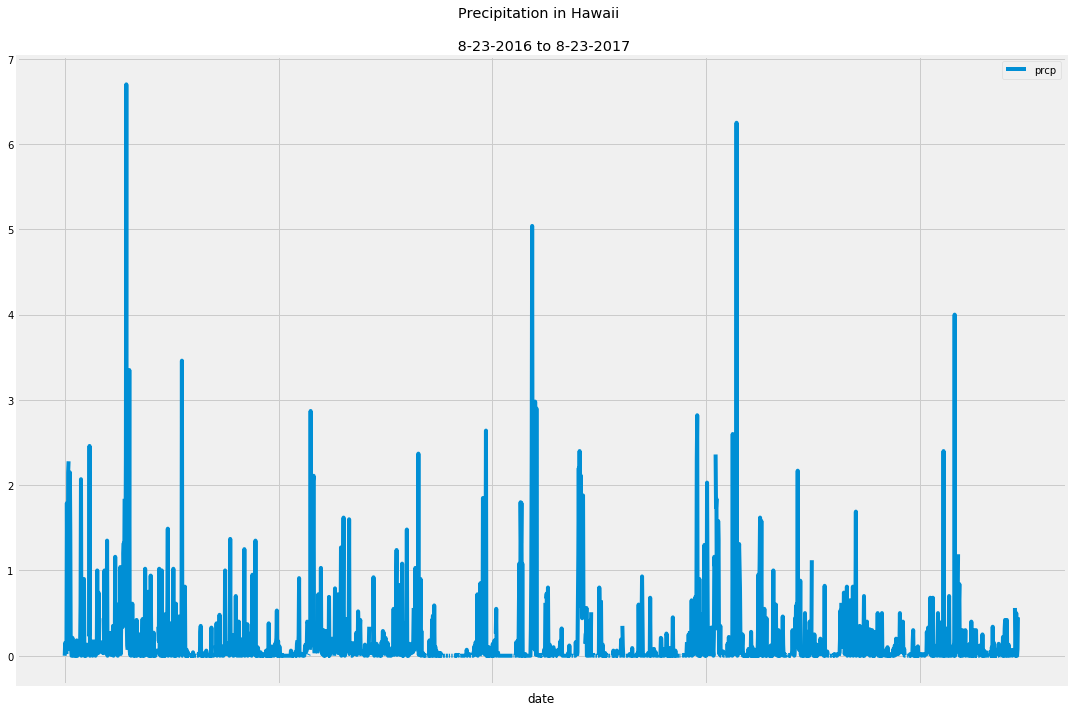

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


precip_last = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).first()
end_date_numbers = precip_last[0].split('-')
now = dt.date(int(end_date_numbers[0]), int(end_date_numbers[1]), int(end_date_numbers[2]))

# Calculate the date 1 year ago from the last data point in the database
year_ago = now - dt.timedelta(days=365)
print(year_ago)
print(precip_last)
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
                order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df.set_index('date', inplace=True)
precip_df.head(20)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(15,10), title='Precipitation in Hawaii \n\n 8-23-2016 to 8-23-2017')
plt.tight_layout()
plt.show()

In [14]:
for observation in precip_data:
    precip_dict = {}

    precip_dict[observation.date] = observation.prcp

precip_dict

{'2017-08-23': 0.45}

In [43]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [51]:
# Design a query to show how many stations are available in this dataset?
no_of_stations = session.query(Station.id).distinct().count()
print(no_of_stations)

9


In [21]:
station_list = session.query(Station.name, Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
print(station_list)

[('MANOA LYON ARBO 785.2, HI US', 'USC00519281', 24948), ('MANOA LYON ARBO 785.2, HI US', 'USC00519397', 24516), ('MANOA LYON ARBO 785.2, HI US', 'USC00513117', 24381), ('MANOA LYON ARBO 785.2, HI US', 'USC00519523', 24021), ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 23508), ('MANOA LYON ARBO 785.2, HI US', 'USC00514830', 19818), ('MANOA LYON ARBO 785.2, HI US', 'USC00511918', 17811), ('MANOA LYON ARBO 785.2, HI US', 'USC00517948', 12348), ('MANOA LYON ARBO 785.2, HI US', 'USC00518838', 4599)]


In [19]:
station_list[0]

('MANOA LYON ARBO 785.2, HI US', 'USC00519281', 24948)

In [24]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
# List the stations and the counts in descending order.
print(station_activity)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == station_activity[0][0]).all()
temp_data

[(54.0, 85.0, 71.66378066378067)]

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_obs = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date >= year_ago).\
                filter(Measurement.station == station_activity[0][0]).order_by(Measurement.date).all()
obs_dates = []
obs_temps = []
freq_ticks = np.arange(0,61,10)
for item in station_obs:
    obs_dates.append(item[1])
    obs_temps.append(item[2])

freq_counter = collections.Counter(obs_temps)
print(freq_counter)

obs_fig = plt.figure()
obs_fig.set_figheight(10)
obs_fig.set_figwidth(15)
plt.hist(obs_temps, bins=12)
plt.yticks(freq_ticks)
plt.title('Frequency of Temperatures for Year 8-23-2016 to 8-23-2017', fontsize=14)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.show()

In [29]:
station_temps = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date >= year_ago).\
                order_by(Measurement.date).all()
station_temps

[('USC00519397', '2016-08-23', 81.0),
 ('USC00513117', '2016-08-23', 76.0),
 ('USC00514830', '2016-08-23', 80.0),
 ('USC00517948', '2016-08-23', 80.0),
 ('USC00519523', '2016-08-23', 80.0),
 ('USC00519281', '2016-08-23', 77.0),
 ('USC00516128', '2016-08-23', 74.0),
 ('USC00519397', '2016-08-24', 79.0),
 ('USC00513117', '2016-08-24', 76.0),
 ('USC00514830', '2016-08-24', 80.0),
 ('USC00517948', '2016-08-24', 78.0),
 ('USC00519523', '2016-08-24', 79.0),
 ('USC00519281', '2016-08-24', 77.0),
 ('USC00516128', '2016-08-24', 74.0),
 ('USC00519397', '2016-08-25', 80.0),
 ('USC00513117', '2016-08-25', 77.0),
 ('USC00514830', '2016-08-25', 81.0),
 ('USC00517948', '2016-08-25', 81.0),
 ('USC00519523', '2016-08-25', 80.0),
 ('USC00519281', '2016-08-25', 80.0),
 ('USC00516128', '2016-08-25', 77.0),
 ('USC00519397', '2016-08-26', 79.0),
 ('USC00513117', '2016-08-26', 78.0),
 ('USC00514830', '2016-08-26', 81.0),
 ('USC00517948', '2016-08-26', 81.0),
 ('USC00519523', '2016-08-26', 84.0),
 ('USC005192

In [55]:
start='2017-08-23'
start_date = dt.datetime.strptime(start, '%Y-%m-%d').date()
temp_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).all()
start_date

datetime.date(2017, 8, 23)

In [86]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [34]:
start_date = '2012-02-28'

temp_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).all()
temp_result = list(np.ravel(temp_results))

temp_dict = {}
temp_dict['min temp'] = temp_result[0]
temp_dict['avg temp'] = temp_result[1]
temp_dict['max temp'] = temp_result[2]

temp_dict

[53.0, 73.43127438710152, 87.0]


{'min temp': 53.0, 'avg temp': 73.43127438710152, 'max temp': 87.0}

In [89]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_data = calc_temps('2011-02-28', '2011-03-05')
print(trip_data)

[(61.0, 69.75510204081633, 75.0)]


14.0
69.75510204081633


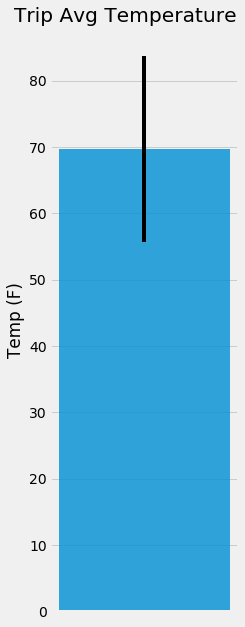

In [122]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = trip_data[0][2] - trip_data[0][0]
trip_avg = trip_data[0][1]
print(peak_to_peak)
print(trip_avg)
trip_yticks = np.arange(0,81,10)
trip_fig = plt.figure()
trip_fig.set_figheight(10)
trip_fig.set_figwidth(3)
plt.bar(0,trip_avg, alpha=.8, yerr=peak_to_peak)
plt.title('Trip Avg Temperature', x= .4)
plt.ylabel('Temp (F)')
plt.xticks([])
plt.yticks(trip_yticks)

plt.show()

In [253]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall = session.query(*sel).filter(Station.station == Measurement.station).filter(Measurement.date >= '2011-02-28')\
            .filter(Measurement.date <= '2011-03-05').group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  2.33),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.23),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.96),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.45),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.38),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.63),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [158]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [225]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = dt.date(2012, 2, 28)
trip_end = dt.date(2012, 3, 5)

# Use the start and end date to create a range of dates
trip_days = (trip_end - trip_start).days
print(trip_days)
trip_dates = [trip_start + dt.timedelta(days = x) for x in range(0,trip_days + 1)] #DT DOESN'T ACCOUNT FOR LEAP YEAR?
print(trip_dates)
# Stip off the year and save a list of %m-%d strings
month_day= []
normals = []
for day in trip_dates:
    month_day.append(day.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in month_day:
    normals.append(daily_normals(day))
print(normals)
dates_index = [day.strftime("%Y-%m-%d") for day in trip_dates]
normals_df = pd.DataFrame(normals, columns=['stuff'])

new_df = pd.DataFrame(normals_df['stuff'].values.tolist(), columns=['min', 'avg', 'max'])
new_df['date'] = dates_index
print(new_df.dtypes)
new_df.set_index('date', inplace=True)
new_df
#new_df.set_index(dates_index, inplace=True)

6
[datetime.date(2012, 2, 28), datetime.date(2012, 2, 29), datetime.date(2012, 3, 1), datetime.date(2012, 3, 2), datetime.date(2012, 3, 3), datetime.date(2012, 3, 4), datetime.date(2012, 3, 5)]
[[(65.0, 70.65517241379311, 80.0)], [(67.0, 71.73333333333333, 79.0)], [(64.0, 70.0327868852459, 76.0)], [(61.0, 70.36666666666666, 78.0)], [(60.0, 70.06896551724138, 78.0)], [(57.0, 69.27272727272727, 77.0)], [(60.0, 67.89090909090909, 76.0)]]
min     float64
avg     float64
max     float64
date     object
dtype: object


,min,avg,max
date,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


In [186]:
cols = ['stuff']
test_df = [pd.DataFrame(normals_df[x].values.tolist(), columns=['min', 'avg', 'max']) for x in cols]
new_test_df = pd.concat(test_df, axis=1)
new_test_df

,min,avg,max
0,65.0,70.655172,80.0
1,67.0,71.733333,79.0
2,64.0,70.032787,76.0
3,61.0,70.366667,78.0
4,60.0,70.068966,78.0
5,57.0,69.272727,77.0
6,60.0,67.890909,76.0


In [226]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
new_df

,min,avg,max
date,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


Text(0, 0.5, 'Temp (F)')

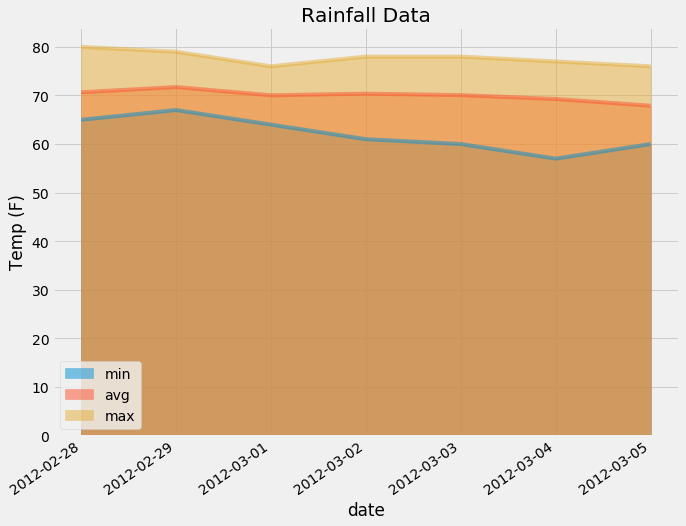

In [257]:
# Plot the daily normals as an area plot with `stacked=False`
new_df.reset_index().plot(kind='area', x='date', y=['min', 'avg', 'max'], stacked=False, xticks=[0,1,2,3,4,5,6], rot=35,
                         figsize=(10,7), title='Rainfall Data')

plt.xticks(ha='right')
plt.ylabel('Temp (F)')